# Milestoning on the Muller potential

In [1]:
%matplotlib inline
from IPython.display import IFrame
n = 0

## The Muller potential revisited

We are going to use Milestoning and long trajectories to estimate the mean first passage time between two regions of the energy landscape corresponding to the Muller potential.

To run our simulation we will use a general purpose tool called `miles` that uses a third-party molecular dynamics code.  In this case, the MD code is called `simple-brownian-dynamics` and it is included with this tutorial. However, it is possible to use this tool with other MD codes such as NAMD and Moil.

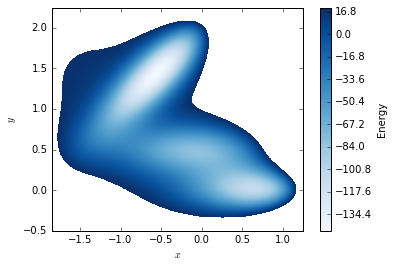

In [2]:
from potential import Potential
Potential().plot()

## Before we start...

Before starting to work, copy the contents of 03/files to the current working directory as follows:

    cp 03/input-files/* .

In [3]:
n += 1; IFrame('http://localhost:8888/terminals/{}'.format(n), width=800, height=600)

## The configuration file.

First of all, we must write a configuration file named `muller.cfg` detailing several features of the simulation. For the purposes of this tutorial it will be enough to edit the provided configuration file, whose contents are shown below, instead of writing it from scratch:

```
simulation_dir = ~/sources/miles/muller
temp_dir = /tmp
md_template_reset_velocities = template.sbd
md_template = template.sbd
md_engine = simple-brownian-dynamics 
database_file = ${simulation_dir}/database
reactant_distribution = ${simulation_dir}/reactant.dst
product_milestone = 0, 1
steps_per_chunk = 100
time_step_length = 5e-5
logging_level = 20
num_collective_variables = 2
```

Don't worry about the specific settings for now. The only thing you need to make sure at this point is that `simulation_dir` is correctly set. Its value should be the current working directory (to find out which directory that is, type `pwd` in the command line).

Now go ahead and inspect / edit the file `muller.cfg`.

In [4]:
n += 1; IFrame('http://localhost:8888/terminals/{}'.format(n), width=800, height=600)

Next, we must create an input file for the underlying MD engine. This is a template that `miles` will fill before passing it to the MD engine. The contents of this file should look like:

```
${inputname}
12.5
${time_step_length}
${steps_per_chunk}
${random_seed}
${outputname}
```

The **number 12.5 in the second line is the temperature** at which the simulation will be run. We will change this later on but for now make sure that there is a file named `template.sbd` with the contents shown above.

In [5]:
n += 1; IFrame('http://localhost:8888/terminals/{}'.format(n), width=800, height=600)

## Setting up the milestones

We begin by creating a set of milestones. We do so by definining anchor points on the phase space. Since we are using Brownian dynamics, this means we need to specify a set of two dimensional points.  Those points are stored in a file called anchors.csv.

Open a terminal and inspect the file anchors.csv, then begin to set up the milestoning simulation by running:

    miles mkdb muller.cfg --anchors anchors.csv
    
This command creates two files in the current directory: `database.db` and `database.zip`. These two files will store information about the simulation such as the anchors and known phase space points at the milestones.
    
The anchors defined in the file `anchors.csv` are:

Anchor index | x coordinate | y coordinate
-------------|--------------|---------------
0|-0.558233|1.441716
1|-0.791456|1.204913
2|-0.96376|0.928591
3|-0.82967|0.635026
4|-0.52692|0.508198
5|-0.19585|0.480018
6|0.122775|0.403274
7|0.318357|0.135884
8|0.623499|0.028038

If you revisit `muller.cfg`, you will see that there is a line that reads "`product_milestone = 0, 1`".  This line means that we will be designating the milestone determined by anchors #0 and #1 as the product.

In [6]:
n += 1; IFrame('http://localhost:8888/terminals/{}'.format(n), width=800, height=600)

Plot the potential energy and the milestones issuing the command:

    miles plot muller.cfg --scatter --voronoi --title 'Potential energy'
    
A window will be opened displaying something like:

<img src="figures/voronoi.png" width="500"></img>

The dashed lines are the milestones determined by the anchors.

In [7]:
n += 1; IFrame('http://localhost:8888/terminals/{}'.format(n), width=800, height=600)

 ## Populating the initial distributions on the milestones
 
 Now that we have defined the set of milestones, it is time to generate a set of initial distributions on the milestones. Typically we choose the initial distributions to coincide with the canonical (Gibbs) distribution conditioned to being at the milestone.
 
In practice, we need to obtain an empirical distribution that will provide us with initial points to sample from. In order to obtain the initial distribution there are several options available, (umbrella sampling, running trajectories at high temperature, etc.). Since the Muller potential is sufficiently simple, we can construct our initial distributions by running a Metropolis sampler on each milestone and gathering all the sampled points.

We have included a script called `sample-milestones` that does this. This script requires that we specify the temperature (recall that it was original set to be equal to 12.5). The command to run should be:

    ./sample-milestones 12.5 1 10000 110000 100 muller.cfg

The four numbers in the middle are intended to tune the Metropolis sampler for this particular potential. If you are curious about how this works, feel free to look at the source code of `sample-milestones`. In any case, run the program as specified above.

In [8]:
n += 1; IFrame('http://localhost:8888/terminals/{}'.format(n), width=800, height=600)

The previous step populates the database of phase space points with a set of initial points at the milestones.

Next, we must create two so-called distribution files: `canonical.dst` and `reactant.dst`. These are files containing empirical distributions. The first will be used as an initial guess for a milestoning simulation and the second file determines the distribution at the reactant. To create them, run:

    miles mkdist muller.cfg --output canonical.dst
    miles mkdist muller.cfg --output reactant.dst --milestone 7,8
    
The last line means that the reactant will be concentrated solely on the milestone determined by anchors #7 and #8.

In [9]:
n += 1; IFrame('http://localhost:8888/terminals/{}'.format(n), width=800, height=600)

Let's take a look at the output from the previous step. We can visualize the distributions by running:
    
    miles plot muller.cfg --histograms --input canonical.dst
    
You should see something resembling:

<img src="figures/canonical-distribution.png" width="800" alt="Initial empirical distributions"></img>

In [10]:
n += 1; IFrame('http://localhost:8888/terminals/{}'.format(n), width=800, height=600)

## Running the simulation

Before running the simulation, let us back up the contents of the database and the distributions so that we may use them later.

    mkdir backup
    cp database.db database.zip canonical.dst reactant.dst backup

At this point we have everything that's needed to run a milestoning simulation. We can start the simulation with the command:

    miles run muller.cfg --input canonical.dst --max-iterations 10 \
                         --samples 100 --local-tolerance 1e-2 2>&1 | tee log


In [11]:
n += 1; IFrame('http://localhost:8888/terminals/{}'.format(n), width=800, height=600)

The mean first passage times obtained throughout the iterations should be around 1.5. Inspect it as follows:

    grep "Mean first passage time" log
    
Additionally, you may want to take a look at the first hitting points and the vector of stationary fluxes $q$. For that, run:

    miles plot --voronoi --scatter muller.cfg --input q-global-0009.dat --title 'Stationary-flux'

You should see a figure like this:

<img src="figures/stationary-flux.png" width="500" alt="Stationary flux"></img>

To check out the distributions of first hitting points at the last iteration in more detail, run:

    miles plot --histograms muller.cfg --input initial-global-0010.dat --num-bins 100
    
This will render a set of histograms similar to:

<img src="figures/final-first-hitting-point-distributions.png" width="800" alt="First hitting point distributions at the last iteration"></img>

In [12]:
n += 1; IFrame('http://localhost:8888/terminals/{}'.format(n), width=800, height=600)

Also, it is good practice now to save the output of the simulation to a different folder. We do so by writing:

    mkdir results-miles-run
    mv log database.{db,zip} *.{dst,dat,mtx} results-miles-run

In [13]:
n += 1; IFrame('http://localhost:8888/terminals/{}'.format(n), width=800, height=600)

## Comparison with straight-forward dynamics.

Let's check what happens when we run straight-forward molecular dynamics (that is, no milestoning or enhanced sampling of any type) and estimate the MFPT. In order to get the MFPT by running trajectories all the way from the reactant to the product, restore the original database from its backup:

    cp backup/* .
    
and then run:

    miles long muller.cfg 2>&1 | tee log

In [14]:
n += 1; IFrame('http://localhost:8888/terminals/{}'.format(n), width=800, height=600)

After the straight-forward simulations are finished we can inspect the results. In particular, we want to see what is the estimated mean first passage time:

    miles analyze muller.cfg

In [15]:
n += 1; IFrame('http://localhost:8888/terminals/{}'.format(n), width=800, height=600)

The results for the MFPTs should be in the vicinity of what was obtained using milestoning. We can go a step further and inspect the empirical stationary distribution obtained by both methods:

    miles plot --histograms muller.cfg --input results-miles-run/initial-global-0010.dst \
                                       --input stationary-analyze.dst
                                       
The previous command shows the stationary distribution obtained through long trajectories in comparison with the same distribution obtained at the last (that is, the fifth) iteration of the milestoning simulation.

<img src="figures/comparison.png" alt="Comparison of stationary densities between milestoning and molecular dynamics"></img>

The milestones that go along the main reaction path are identified by consecutive anchor numbers (for example: (0, 1), (1, 2), (2, 3), and so on). Observe that the match between the distributions on those milestones should be good while the comparison between the other milestones reveals divergences.  This is because the milestones along the main path are visited very often and we can gather enough statistics about them while the other ones are sparsely sampled and the picture we obtain is less complete.

In [16]:
n += 1; IFrame('http://localhost:8888/terminals/{}'.format(n), width=800, height=600)

## Comparison at a lower temperature.

We have seen both milestoning and straight-forward MD at work. Let us now compare the two methods for a system at a lower temperature. This is equivalent to raising the height of the barriers in the energy landscape.

Carry out the following experiment:

1. Edit template.sbd and change the value of the temperature from 12.5 to 5.
2. Re-run all the steps above and compare Milestoning to MD.

To save time you may copy the contents of the backup directory into the current directory and skip the `miles mkdb`, `sample-milestones`, and `miles mkdist` commands.

In [17]:
n += 1; IFrame('http://localhost:8888/terminals/{}'.format(n-3), width=800, height=600)